# Final Challenge: The Pizza Automation Graph 🍕🤖

## Objective
Build a complex workflow to simulate a fully automated pizzeria from scratch! 
This exercises combines **State Management**, **Conditional Routing**, and **Multiple Loops**.

## The Scenario
Your robot chef needs to handle an order through these stages:
1.  **Check Inventory**: Does the kitchen have enough dough? If `inventory < order_amount`, you must enter a **Restocking Loop** (add to inventory and check again). 
    *   *Safety Component*: If you try to restock more than 3 times, the shop should close (End).
2.  **Prep & Bake**: Prepare the pizza and simulate baking.
3.  **Quality Control**: Check the pizza status.
    *   If "Undercooked", go back to **Bake Node** (Re-bake Loop).
    *   If "Burnt", Stop execution (Fail).
    *   If "Perfect", proceed.
4.  **Delivery Routing**: Decide the delivery method based on distance.
    *   Distance < 5km: Route to "Bike Delivery Node"
    *   Distance >= 5km: Route to "Car Delivery Node"

## Requirements
1.  **Define your own State**: You need to track inventory, pizza status, and counters for loops.
2.  **Implements 5+ Nodes**: `check_inventory`, `restock`, `prep`, `bake`, `quality_control`, etc.
3.  **Implement 2 Loops**: One for restocking, one for re-baking.
4.  **No LLMs**: Use pure python logic.

## Test Scenarios
Use these inputs to verify your graph logic.

In [52]:
# Scenario 1: Happy Path (Perfect run)
# Expected: Inventory decreases, Status becomes Perfect, Delivery via Bike
input_1 = {
    "orders": 1,
    "distance_km": 2,
    "inventory_dough": 5,
    "restock_attempts": 0,
    "bake_time": 9 # Sufficient time (starts at 9, bake adds 1 -> 10 = Perfect)
}

# Scenario 2: Low Stock (Needs Restock Loop)
# Expected: Restock node runs, Inventory increases, then proceeds
input_2 = {
    "orders": 5,
    "inventory_dough": 1, # Not enough!
    "restock_attempts": 0,
    "bake_time": 10
}

# Scenario 3: Undercooked (Needs Re-bake Loop)
# Expected: Bake node runs twice (or more), Status changes from Undercooked -> Perfect
input_3 = {
    "orders": 1,
    "distance_km": 10, # Delivery via Car
    "inventory_dough": 5,
    "restock_attempts": 0,
    "bake_time": 0 # Too short to start with
}

In [53]:
### Your Code Below
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END
import random
from IPython.display import display, Image

# TODO: GOOD LUCK! 👨‍🍳

In [54]:
class AgentState(TypedDict):
    orders: int
    distance_km: int
    inventory_dough: int
    pizza_status: str
    restock_attempts: int
    bake_time: int
    delivery_method: str
    final_output: str

In [55]:
def check_inventory(state: AgentState) -> AgentState:
    print("Checking inventory...")
    return state
    
def restock(state: AgentState) -> AgentState:
    print("Restocking...")
    state["inventory_dough"] = state["inventory_dough"] * 2
    state["restock_attempts"] = state.get("restock_attempts", 0) + 1
    return state

def prep(state: AgentState) -> AgentState:
    print("Prepping...")
    state["inventory_dough"] = state["inventory_dough"] - state["orders"]
    return state

def bake(state: AgentState) -> AgentState:
    print("Baking...")
    state["bake_time"] = state["bake_time"] + 1
    return state

def quality_control(state: AgentState) -> AgentState:
    print("Quality control...")
    if state["bake_time"] < 10:
        state["pizza_status"] = "Undercooked"
    elif state["bake_time"] > 10:
        state["pizza_status"] = "Burnt"
    else:
        state["pizza_status"] = "Perfect"
    return state

def delivery(state: AgentState) -> AgentState:
    print("Delivery...")
    if state["distance_km"] < 5:
        state["delivery_method"] = "Bike"
    else:
        state["delivery_method"] = "Car"
    return state

def bike(state: AgentState) -> AgentState:
    print("Your order is on the way!")
    state["final_output"] = f"Your order is ready in {state['bake_time']} minutes and will be delivered by bike"
    return state

def car(state: AgentState) -> AgentState:
    print("Your order is on the way!")
    state["final_output"] = f"Your order is ready in {state['bake_time']} minutes and will be delivered by car"
    return state

def restock_router(state: AgentState) -> str:
    if state["restock_attempts"] > 3:
        return "END"
        
    if state["inventory_dough"] < state["orders"]:
        return "restock"
    else:
        return "prep"
def qc_router(state: AgentState) -> str:
    if state["pizza_status"] == "Undercooked":
        return "bake"
    elif state["pizza_status"] == "Burnt":
        return "END"
    else:
        return "delivery"

def delivery_router(state: AgentState) -> str:
    if state["delivery_method"] == "Bike":
        return "bike"
    else:
        return "car"



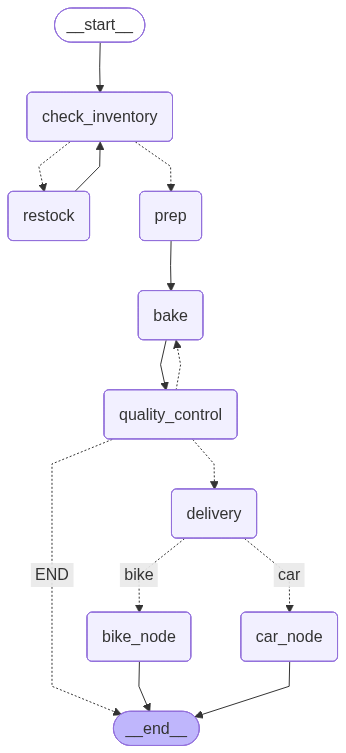

In [56]:
graph = StateGraph(AgentState)
graph.add_node("check_inventory", check_inventory)
graph.add_node("restock", restock)
graph.add_node("prep", prep)
graph.add_node("bake", bake)
graph.add_node("quality_control", quality_control)
graph.add_node("delivery", delivery)
graph.add_node("bike_node", bike)
graph.add_node("car_node", car)

graph.add_edge(START, "check_inventory")
graph.add_conditional_edges(
    "check_inventory",
    restock_router,
    {
        "restock": "restock",
        "prep": "prep"
    }
)
graph.add_edge("restock", "check_inventory")
graph.add_edge("prep", "bake")
graph.add_edge("bake", "quality_control")
graph.add_conditional_edges(
    "quality_control",
    qc_router,
    {
        "bake": "bake",
        "END": END,
        "delivery": "delivery"
    }
)
graph.add_conditional_edges(
    "delivery",
    delivery_router,
    {
        "bike": "bike_node",
        "car": "car_node"
    }
)
graph.add_edge("bike_node", END)
graph.add_edge("car_node", END)

app = graph.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [57]:
print("\n--- RUNNING SCENARIO 1: Happy Path ---")
result_1 = app.invoke(input_1)
print(f"Final Output: {result_1.get('final_output', 'Process Failed or Ended Early')}")
print(f"Inventory Left: {result_1['inventory_dough']}")

print("\n--- RUNNING SCENARIO 2: Low Stock (Needs Restock) ---")
# Note: restock doubles inventory from 1 to 2, then 4, then 8. 
# Order is 5. So it needs 3 restock cycles (1->2->4->8).
result_2 = app.invoke(input_2)
print(f"Final Output: {result_2.get('final_output', 'Process Failed or Ended Early')}")
print(f"Inventory Left: {result_2['inventory_dough']}")

print("\n--- RUNNING SCENARIO 3: Undercooked (Needs Re-bake) ---")
# Note: bake_time starts at 0. Bake adds +1. QC needs 10.
# It should loop ~10 times.
result_3 = app.invoke(input_3)
print(f"Final Output: {result_3.get('final_output', 'Process Failed or Ended Early')}")
print(f"Final Bake Time: {result_3['bake_time']}")


--- RUNNING SCENARIO 1: Happy Path ---
Checking inventory...
Prepping...
Baking...
Quality control...
Delivery...
Your order is on the way!
Final Output: Your order is ready in 10 minutes and will be delivered by bike
Inventory Left: 4

--- RUNNING SCENARIO 2: Low Stock (Needs Restock) ---
Checking inventory...
Restocking...
Checking inventory...
Restocking...
Checking inventory...
Restocking...
Checking inventory...
Prepping...
Baking...
Quality control...
Final Output: Process Failed or Ended Early
Inventory Left: 3

--- RUNNING SCENARIO 3: Undercooked (Needs Re-bake) ---
Checking inventory...
Prepping...
Baking...
Quality control...
Baking...
Quality control...
Baking...
Quality control...
Baking...
Quality control...
Baking...
Quality control...
Baking...
Quality control...
Baking...
Quality control...
Baking...
Quality control...
Baking...
Quality control...
Baking...
Quality control...
Delivery...
Your order is on the way!
Final Output: Your order is ready in 10 minutes and will